# Brad Evans: Flame-bait or Lame-bait?

[Blurb on why I'm doing this.]

## Methodology

Since Yahoo went with the infinite scrolling UI, pulling up old articles directly from the site became impossible. Thankfully there's Google. Using the following Google search, I can pull back every Flame/Lame call Brad has ever made:

site:sports.yahoo.com/blogs/fantasy-roto-arcade intitle:flames +2012 "Week 10"

site:sports.yahoo.com/blogs/fantasy-roto-arcade intitle:lames +2010 "Week 6"

There is a little manual work involved. Basically, I clicked to the last search result page, and clicked the link that said 

In order to show you the most relevant results, we have omitted some entries very similar to the 85 already displayed.
If you like, you can repeat the search with the omitted results included.

After passing all the captcha tests to prove to google and myself that I was human, I proceeded to Ctrl+A Ctrl+C each page of search results. Google obfuscates URLs, but thankfully, Yahoo's were just the right length for inferrance -

I also used Twitter and Internet Archive: 

flames OR lames @yahoonoise since:2011-01-01 until:2012-01-1

Basically, just use this regex in Vim, and you've got yourself a workable URL. 

:%s/\/\.\.\.\//\/blogs\/fantasy-roto-arcade\//



Yahoo's formats were terribly inconsistent. Bloated. 
Handling Updates.
Brad was a little more fearful early on (2010), suggesting a list of potential flames/lames in addition to his fearless forecasts.
Brad is mostly concerned with flames for 12-man leagues and deaper (prove this)
Under what conditions is Brad usually correct?

SHOCKER SPECIAL
BONUS SHOCKER (2011- week 2)
Attempting to fix missing data by padding with prefixes

Brad definitely didn't make this to be machine readable

A sample of formats (after heavily pre-processed) looks like this:

2009 
Josh Freeman, TB, QB (Noise QB Rank: 11, Start: 12-plus team leagues, 2% started)
Matchup: vs. NO
[WITTY BLURB]
Fearless Forecast: 19-33, 217 passing yards, 2 touchdowns, 1 interception, 24 rushing yards, 19 fantasy points

2010
Thomas Jones, KC, RB (Noise Week 11 RB Rank: 17, 53-percent started)
Matchup: vs. Ari
[WITTY BLURB]
Fearless Forecast: 19 carries, 95 rushing yards, 1 receptions, 4 receiving yards, 1 touchdown, 15 fantasy points

2011
Ben Tate, Hou, RB (Week 3 Noise RB Rank: 9, 22-percent started)
Matchup: at NO
[WITTY BLURB]
Fearless Forecast: 25 carries, 119 rushing yards, 4 receptions, 24 receiving yards, 1 touchdown, 23.3 fantasy points

2011
Michael Vick, Phi, QB (Noise Week 11 QB Rank: 13, 72-percent started)
Matchup: at NYG
[WITTY BLURB]
Fearless Forecast: 17-29, 193 passing yards, 1 touchdown, 2 interceptions, 27 rushing yards, 14.4 fantasy points

2012
Willis McGahee, Den, RB (78-percent started)
Matchup: vs. SD
[WITTY BLURB]
Fearless Forecast: 17 carries, 62 rushing yards, 3 receptions 21 receiving yards, 0 touchdowns, 10.5 fantasy points

2013
Matt Ryan, Atl, QB (53-percent started)
Matchup: at TB
[WITTY BLURB]
Fearless Forecast: 241 passing yards, 1 passing touchdown, 2 interceptions, 5 rushing yards, 14.5 fantasy points

2014
Ben Roethlisberger, Pit, QB (60 percent started)
Matchup: at Ten
[WITTY BLURB]
Fearless Forecast: 25-39, 266 passing yards, 1 passing touchdown, 1 interception, 16.3 fantasy points

2015
Matt Jones, Was, RB (10 percent started, $17)
Matchup: at NYG
[WITTY BLURB]
Fearless Forecast: 13 carries, 66 rushing yards, 3 receptions, 14 receiving yards, 1 touchdown, 15.5 fantasy points

This is fairly consistent now. The major difference going from 2009 to 2015, is in the rank. We start out with a "Noise Rank", and a league depth gague, but eventually just come down to a percent started, and this year, a dollar value added (for FanDuel, no doubt). 

Seeing as how this is Brad, I automatically assume it's geared toward AT LEAST 10 team leagues, but more likely 12. Basically, those in desparation. So I don't need that, nor do I need the out-of-context rank or the week, since we are given that. Dollar value could be interesting, if we were to extend this to daily leagues, so I'll keep that. 

Of course, none of this is easy, as there is no consistency. Sometimes he says the type of rank ("WR Rank") and others, just Rank. Sometimes the percentage is in numeric, other times he spells it out (two-percent). 

Lots of manual work here.

Then there's the Fearless Forecast part. Brad sometimes includes caveats "(Cutler or McCown), (minus Jones)" etc. So I've moved those up to the blurb. Sorry, Brad. Shit or get off the pot. And if you can't make a decision, I'll make one for you.

Year
Player_First_Name Player_Last_Name, Team_Abbreviation, Position (Percent_Started, [Daily_League_Dollar_Amt])
Matchup: [vs.|at] Team_Abbreviation
WITTY_BLURB
Fearless Forecast: [[0-9]*-[0-9]*,] 13 carries, 66 rushing yards, 3 receptions, 14 receiving yards, 1 touchdown, 15.5 fantasy points

Alright, let's start parsing.

For the Fearless Forecast, most of it was pretty consistent, but I took a few liberties. Like in 2009, Brad liked to mark people down for just yards. Not specific yards, like receiving, rushing, or passing. So if it was a WR, I changed it to receiving yards, etc. 

In [470]:
import pprint
import re
from pprint import pprint
import os

from os import listdir
from os.path import isfile, join
from os import walk

import pickle

mypath = '/home/bdetweiler/src/Data Science/brad-evans-analysis/data'
# This is what we're trying to populate
flames_lames_dict = dict()
flame_lame_id = 0

for root, subdirs, files in os.walk(mypath):
    if 'preseason' in root: continue
    if 'free_agent' in root: continue
    for fileName in files:
        if not 'txt' in fileName: continue
        if '.swp' in fileName: continue # happens when editing in Vim
        #if not '2014' in root: continue
        #if not 'week_03' in root: continue
        
        year = float('NaN')
        week = float('NaN')
        flame_lame = ''
        
        m = re.match(".*(20[0-9][0-9])/week_([0-9][0-9])", root)
        if m is not None:
            year = m.group(1)
            week = m.group(2)
        else:
            continue
        
        m = re.match("(flames|lames)\.txt", fileName)
        if m is not None:
            flame_lame = m.group(1)
        
        
        with open(root + '/' + fileName, 'r') as infile:
            data = infile.read()
            my_list = data.splitlines()
            
            player = ''
            matchup = ''
            blurb = ''
            fearless_forecast = ''
            
            # initialize variables
            player_name = ''
            player_team = ''
            player_position = ''
            player_percent_started = float('NaN')
            shocker_special = False

            attempts = float('NaN') 
            carries = float('NaN')
            completions = float('NaN')
            fantasy_points = float('NaN')
            fumbles_lost = float('NaN')
            fumbles_recovered = float('NaN')
            interceptions = float('NaN')
            defensive_interceptions = float('NaN')
            interceptions = float('NaN')
            passing_yards = float('NaN')
            passing_touchdowns = float('NaN')
            points_allowed = float('NaN')
            receiving_yards = float('NaN')
            receptions = float('NaN')
            rushing_touchdowns = float('NaN')
            rushing_yards = float('NaN')
            sacks = float('NaN')
            total_touchdowns = float('NaN')
            turnovers = float('NaN')
            total_yards = float('NaN')
            shocker = False
            
            # Matchup
            home = False
            away = False
            opponent = ''
            
            count = 0
            
            # Date is always first line of file
            date_posted = my_list[0]
            
            # Begin processing file
            for line in my_list:
               
                # we already have the date
                if date_posted in line: continue 
                
                # Skips some of Brad's notes at the end of the file
                if '// Other' in line: continue
                
                if count == 1:
                    player_name = ''
                    player_team = ''
                    player_position = ''
                    player_percent_started = float('NaN')
                    shocker_special = False
                    
                    attempts = float('NaN') 
                    carries = float('NaN')
                    completions = float('NaN')
                    fantasy_points = float('NaN')
                    fumbles_lost = float('NaN')
                    fumbles_recovered = float('NaN')
                    interceptions = float('NaN')
                    defensive_interceptions = float('NaN')
                    interceptions = float('NaN')
                    passing_yards = float('NaN')
                    passing_touchdowns = float('NaN')
                    points_allowed = float('NaN')
                    receiving_yards = float('NaN')
                    receptions = float('NaN')
                    rushing_touchdowns = float('NaN')
                    rushing_yards = float('NaN')
                    sacks = float('NaN')
                    total_touchdowns = float('NaN')
                    turnovers = float('NaN')
                    total_yards = float('NaN')
                    
                    # Matchup
                    home = False
                    away = False
                    opponent = ''
                    
                
                count += 1
                
                if count == 1: continue # Blank new line separator
                elif count == 2:
                    player = line
                    
                    m = re.match("^([A-Za-z\s.\-\']*), ([A-Za-z]*), ([A-Z/]*) \(([0-9]*)[%]?\)(, SHOCKER SPECIAL)?", player)
                    if m is not None:
                        if m.group(1) is not None:
                            player_name = m.group(1)
                            player_team = m.group(2)
                            player_position = m.group(3)
                            if m.group(4) is not None:
                                try:
                                    player_percent_started = float(m.group(4)) * .01
                                except (ValueError):
                                    player_percent_started = float('NaN')
                            if m.group(5) is not None:
                                shocker_special = True
                            else:
                                shocker_special = False


                    continue
                    
                elif count == 3:
                    matchup = line
                        
                    m = re.match("Matchup: (vs\.|at) ([A-Za-z]*)", matchup)
                    if m is not None:
                        if m.group(1) == 'vs.':
                            home = True
                        else:
                            away = True
                    
                        opponent = m.group(2)

                            
                    continue
                    
                elif count == 4:
                    blurb = line

                    continue
                    
                elif count == 5:
                    fearless_forecast = line

                        
                    m = re.match("Fearless Forecast: (([0-9]*) (carries))", fearless_forecast)
                    if m is not None:
                        carries = m.group(2)
        
                    m = re.match(".*(( ([0-9]+\.[0-9]+))|( ([0-9]+)) fantasy points)", fearless_forecast)
                    if m is not None:
                        if m.group(3) is not None:
                            fantasy_points = m.group(3)
                        elif m.group(5) is not None:
                            fantasy_points = m.group(5)

                    m = re.match("Fearless Forecast: ([0-9]+)-([0-9]+),", fearless_forecast)
                    if m is not None:
                        completions = m.group(1)
                        attempts = m.group(2)
                    
                    m = re.match(".*, ([0-9]+) fumble recovery", fearless_forecast)
                    if m is not None:
                        fumbles_recovered = m.group(1)
                        
                    m = re.match(".* ([0-9]+) fumble lost", fearless_forecast)
                    if m is not None:
                        fumbles_lost = m.group(1)

                    m = re.match(".* ([0-9]+) interception", fearless_forecast)
                    if m is not None:
                        interceptions = m.group(1)
                    
                    m = re.match(".* ([0-9]+) defensive interception", fearless_forecast)
                    if m is not None:
                        defensive_interceptions = m.group(1)
                        
                    m = re.match(".* ([0-9]+) passing yards", fearless_forecast)
                    if m is not None:
                        passing_yards = m.group(1)
                        
                    m = re.match(".* ([0-9]+) passing touchdown", fearless_forecast)
                    if m is not None:
                        passing_touchdowns = m.group(1)
                            
                    m = re.match(".* ([0-9]+) points allowed", fearless_forecast)
                    if m is not None:
                        points_allowed = m.group(1)

                    m = re.match(".* ([0-9]+) receiving yards", fearless_forecast)
                    if m is not None:
                        receiving_yards = m.group(1)
                        
                    m = re.match(".* ([0-9]+) receptions", fearless_forecast)
                    if m is not None:
                        receptions = m.group(1)

                    m = re.match(".* ([0-9]+) rushing touchdown", fearless_forecast)
                    if m is not None:
                        rushing_touchdowns = m.group(1)

                    m = re.match(".* ([0-9]+) rushing yards", fearless_forecast)
                    if m is not None:
                        rushing_yards = m.group(1)

                    m = re.match(".* ([0-9]+) sack", fearless_forecast)
                    if m is not None:
                        sacks = m.group(1)
                        
                    m = re.match(".* ([0-9]+) total touchdown", fearless_forecast)
                    if m is not None:
                        total_touchdowns = m.group(1)
                    
                    m = re.match(".* ([0-9]+) turnovers", fearless_forecast)
                    if m is not None:
                        turnovers = m.group(1)

                    m = re.match(".* ([0-9]+) total yards", fearless_forecast)
                    if m is not None:
                        total_yards = m.group(1)
                    
                    continue
                    
                count = 1

                flames_lames_dict[flame_lame_id] = {
                    "year": year,
                    "week": week,
                    "date_posted": date_posted,
                    "flame_lame": flame_lame,
                    "player_name": player_name,
                    "player_team": player_team,
                    "player_position": player_position,
                    "player_percent_started": player_percent_started,
                    "shocker_special": shocker_special,
                    
                    "attempts": attempts,
                    "carries": carries,
                    "completions": completions,
                    "fantasy_points": fantasy_points,
                    "fumbles_lost": fumbles_lost,
                    "fumbles_recovered": fumbles_recovered,
                    "interceptions": interceptions,
                    "defensive_interceptions": defensive_interceptions,
                    "interceptions": interceptions,
                    "passing_yards": passing_yards,
                    "passing_touchdowns": passing_touchdowns,
                    "points_allowed": points_allowed,
                    "receiving_yards": receiving_yards,
                    "receptions": receptions,
                    "rushing_touchdowns": rushing_touchdowns,
                    "rushing_yards": rushing_yards,
                    "sacks": sacks,
                    "total_touchdowns": total_touchdowns,
                    "turnovers": turnovers,
                    "total_yards": total_yards,
                    
                    "home": home,
                    "away": away,
                    "opponent": opponent,
                    "blurb": blurb
                }
                
                flame_lame_id += 1

pickle.dump( flames_lames_dict, open( "/home/bdetweiler/src/Data Science/brad-evans-analysis/data/flames_lames.p", "wb" ) )
target = open('/home/bdetweiler/src/Data Science/brad-evans-analysis/data/flames_lames.dict', 'w')
target.write(str(flames_lames_dict))
target.close()



Now all of the scrubbed data is in a nice, usable dict. Let's do some preliminary data exploration.

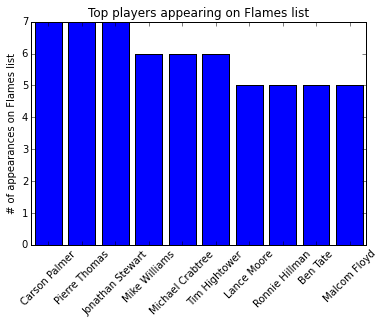

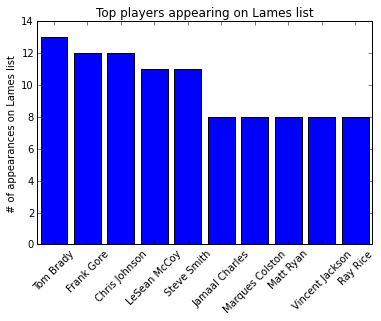

In [496]:
%matplotlib inline
from collections import Counter
from matplotlib import pyplot as plt


flames_lames = pickle.load(open("flames_lames.p", "rb"))

flames_players = []
lames_players = []

for key in flames_lames:
    if flames_lames[key]['flame_lame'] == 'flames':
        flames_players.append(flames_lames[key]['player_name'])
    if flames_lames[key]['flame_lame'] == 'lames':
        lames_players.append(flames_lames[key]['player_name'])

flames_players.sort()
lames_players.sort()

flames_player_name = []
flames_player_count = []

flames_count = Counter(flames_players)

for name, count in flames_count.most_common(10):
    flames_player_name.append(name)
    flames_player_count.append(count)
    
lames_player_name = []
lames_player_count = []
lames_count = Counter(lames_players)

for name, count in lames_count.most_common(10):
    lames_player_name.append(name)
    lames_player_count.append(count)

xs = [i + 0.1 for i, _ in enumerate(flames_player_name)]
plt.bar(xs, flames_player_count)
plt.ylabel('# of appearances on Flames list')
plt.title('Top players appearing on Flames list')
plt.xticks([i + 0.5 for i, _ in enumerate(flames_player_name)], flames_player_name)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)

plt.show()

xs = [i + 0.1 for i, _ in enumerate(lames_player_name)]
plt.bar(xs, lames_player_count)
plt.ylabel('# of appearances on Lames list')
plt.title('Top players appearing on Lames list')
plt.xticks([i + 0.5 for i, _ in enumerate(lames_player_name)], lames_player_name)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)

plt.show()
    

Man, Brad hates Tom Brady. But really, who doesn't? And I've felt like he's always had it out for Chris Johnson (CJ2LAME if I remember correctly), but wasn't he kind of an easy target? At least after 2012 anyway. So that's kinda cool. What about players who appeared on both lists? Does Brad flipflop? 

Carson Palmer has 8 appearances
Darren Sproles has 8 appearances
Pierre Thomas has 9 appearances
LeSean McCoy has 13 appearances
Jamaal Charles has 10 appearances
Knowshon Moreno has 8 appearances
Chris Johnson has 13 appearances
Mike Williams has 8 appearances
Michael Crabtree has 8 appearances
Matt Ryan has 9 appearances
Rashard Mendenhall has 9 appearances
Ryan Mathews has 11 appearances
Steve Smith has 13 appearances
Philip Rivers has 9 appearances
Ben Roethlisberger has 9 appearances
Marshawn Lynch has 9 appearances


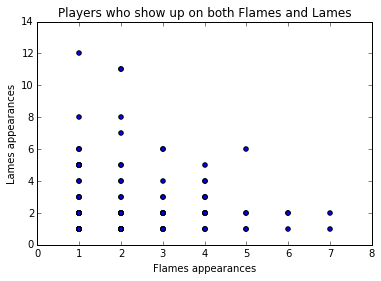

In [491]:
flames_and_lames = set(flames_players).intersection(lames_players)

flames_and_lames_flames_count = []
flames_and_lames_lames_count = []


total_count = 0
for name in flames_and_lames:
    total_count_player = 0
    for flame_name, count in flames_count.most_common():
        if flame_name == name:
            flames_and_lames_flames_count.append(count)
            total_count += count
            total_count_player += count
    for lame_name, count in lames_count.most_common():
        if lame_name == name:
            flames_and_lames_lames_count.append(count)
            total_count += count
            total_count_player += count
    if (total_count_player > 7):
        print(name + ' has ' + str(total_count_player) + ' appearances')

plt.scatter(flames_and_lames_flames_count, flames_and_lames_lames_count)

plt.title("Players who show up on both Flames and Lames")
plt.xlabel('Flames appearances')
plt.ylabel('Lames appearances')

plt.show()

Now it's probably time to grab some NFL data. I was expecting this to be next to impossible, in an automated fashion, but the NFL website is slightly more accommodating than I initially presumed.

Since I'm only interested in player data, and we're only going back to 2009, that makes our search a little more finite.

We begin at the player stats page, located here: http://www.nfl.com/stats/categorystats?tabSeq=1&statisticPositionCategory=QUARTERBACK&season=2015&seasonType=REG

I grab each page with wget. For example, 

wget 'http://www.nfl.com/stats/categorystats?archive=true&conference=null&statisticPositionCategory=QUARTERBACK&season=2009&seasonType=REG&experience=&tabSeq=1&qualified=false&Submit=Go' -O QB_2009_1.txt
wget 'http://www.nfl.com/stats/categorystats?tabSeq=1&season=2009&seasonType=REG&experience=&Submit=Go&archive=true&d-447263-p=2&conference=null&statisticPositionCategory=QUARTERBACK&qualified=false' -O QB_2009_2.txt

Now that we've got all these index pages, we have links to all the players

cat QB_20* | grep profile?id | sed -e 's/^\W*//g; s/a href="/www\.nfl\.com/; s/".*//g' | sort | uniq > qb_all.html

...exception they are redirects. For example,
www.nfl.com/players/brandonweeden/profile?id=WEE221487
redirects to
http://www.nfl.com/player/brandonweeden/2532970/profile

So we need to grab those...

wget -i qb_all.html --max-redirect=0 2>&1 > /dev/null | grep Location | sed -e 's/Location: /www\.nfl\.com/; s/\ .*//g; s/profile/gamelogs/' | sort | uniq > qb_final.txt


Now we've got a direct link to all each player's stats. But we're not out of the woods yet. We need to pull all those down, and then parse those individual files. 

I wrote a shell script that iterates over qb_final.txt and pulls down all the data files:



This does a pretty fantastic job. Remarkably, the NFL does not throttle or do any kind of gatekeeping. I was able to hammer their website with no protest. Thanks, NFL! (The only time you'll hear me say that.)

Now, we've got the raw HTML files, but we need this in some sort of usable format. I like Tab Separated Values, so we'll try to convert to that. The following is a very ugly glued-together script THAT WORKS. I'm not going for style point shere.

Note that ^M is the linefeed character commonly seen in the Microsoft world, but it can give us a lot of headaches if we don't get rid of it up front.

This gives us a new set of files with just the table data. One more step to go to get it in a nice tab-separated values format.




Now we have everything in TSVs. The next step is to get this all into a database so we can query it!